<a href="https://colab.research.google.com/github/atwine/Pneumonia_detection__transfer_learning/blob/master/Pneumonia_Diagnosis_EfficientNetB5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pneumonia Detection
By Atwine Mugume

In this kernel we are goin to apply `Transfer Learning`. 

You have been in that instance where you want to train a model but you don't have a GPU or enough RAM to help you do what you want to do. In this case you are put in a corner. 

Not anymore: you can use transfer learning. Transfer learning is the ability to take an already built model and use the weights of the model to train on your own data.

Just imagine a company like Google, has the resources to train a model over 4 million images for maybe 3 days, over 50+ classes.

With transfer learning you are able to take these models and work with them to solve your own problems.

How amazing is this?  Really amazing.

Let's get into it. 

We are going to be using a model called EfficientnetB5

You can read the paper on Resnet: [Deep Residual Learning for Image Recognition](https://arxiv.org/abs/1512.03385)

##  Kaggle API

In order to get this data in your environment. You will have to download it from Kaggle.com.

You will need to download an authentication token, a json file which you will use in the setup process to work with their data.

## Kaggle Function:

I wrote this function below to help anyone automate the process of using their data from Kaggle.

What you will need:
1- A json file got from kaggle in the same folder as your other data

If you are working on colab you will have un comment out the lines that enable you to upload the json to the cloud platform.

However everything is done by the function below.

Just sit and watch

In [0]:
def kaggle_function():
  print('Please make sure you have downloaded a kaggle .jason token and its somewhere on your local machine') 
  print('\n Let us first of all import the json token to Google Colab here')

  #first let's import the json file into the working directory

  from google.colab import files

  files.upload()

  print('\n Alright sit back and let me handle the rest for you')

  #now that we have imported the kaggle json file let us make the directory needed to keep the json file 
  !mkdir -p ~/.kaggle

  #let's copy the file there to the kaggle folder 
  !cp kaggle.json ~/.kaggle/

  #let us encrypt the file so that we don't get hacked 
  !chmod 600 ~/.kaggle/kaggle.json

  #now let's install kaggle packages

  !pip install kaggle

  print("Success! Here is the Kaggle Competitions List to show this works")

  #let's do a simple listing of the files that kaggle has 
  !kaggle competitions list

  print('\n\nWhat you need to do now is: go to the competition whose data you need and copy the download code and paste it in the next cell')

Now call the Kaggle function then sit tight and watch it go to work!!

In [7]:
kaggle_function()

Please make sure you have downloaded a kaggle .jason token and its somewhere on your local machine

 Let us first of all import the json token to Google Colab here


Saving kaggle.json to kaggle (1).json

 Alright sit back and let me handle the rest for you
Success! Here is the Kaggle Competitions List to show this works
ref                                            deadline             category            reward  teamCount  userHasEntered  
---------------------------------------------  -------------------  ---------------  ---------  ---------  --------------  
digit-recognizer                               2030-01-01 00:00:00  Getting Started  Knowledge       2704           False  
titanic                                        2030-01-01 00:00:00  Getting Started  Knowledge      10920            True  
house-prices-advanced-regression-techniques    2030-01-01 00:00:00  Getting Started  Knowledge       4542            True  
imagenet-object-localization-challenge         2029-12-31 07:00:00  Research         Knowledge         51           False  
competitive-data-science-predict-future-sales  2019-12-31 23:59:00  Playground           Kudos     

After the kaggle API is installed what is left is for you to go to kaggle.com and find the link from which you will download your data into your environment. Such as the one below.

Your data will be downloaded into your environment for you to use.

In [8]:
#let's download the dataset
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

 99% 1.14G/1.15G [00:16<00:00, 110MB/s]
100% 1.15G/1.15G [00:16<00:00, 76.6MB/s]


In [0]:
#lets unzip the file
import zipfile

zipfilePath = ("./chest_xray.zip")
zip = zipfile.ZipFile(zipfilePath)
zip.extractall(".")
zip.close()

In [11]:
#let's install efficient net modules
!pip install efficientnet

  Created wheel for efficientnet: filename=efficientnet-0.0.4-cp36-none-any.whl size=14288 sha256=7d287c30b7e34d1965e9baae2f4bc5376577a96ce4ebe0617947a0717ca703d0
  Stored in directory: /root/.cache/pip/wheels/5c/34/68/a611a699a28239e964ccf144c0e767cdb5439fee82ec5de6e0
Successfully built efficientnet


In [12]:
#I run this command in case the keras pre-installed is not compatible with my code. 
#this installs the lates version from the repository.
!pip install keras

## Import the necessary libraries


In [1]:
import os
import sys
import glob
import matplotlib
import numpy as np
matplotlib.use('agg')
import matplotlib.pyplot as plt
from PIL import Image
import cv2

from keras import __version__
from keras.models import Model
from keras.layers import Dense, AveragePooling2D, GlobalAveragePooling2D, Input, Flatten, Dropout, BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import SGD
from keras.callbacks import ReduceLROnPlateau , ModelCheckpoint , LearningRateScheduler
from keras.preprocessing import image
from keras.models import load_model

#efficientnet
from efficientnet.model import EfficientNetB5

#this import below if now referenced well will cause problems: it has to have the common part in order to run without issues.
import keras.backend.common as K

Using TensorFlow backend.


# Modeling

From here onwards we work on building the model that we are going to train to classify the images.

In [0]:
IM_WIDTH, IM_HEIGHT = 299, 299 
NB_EPOCHS = 20
BAT_SIZE = 16
FC_SIZE = 1024


%matplotlib inline

In [0]:
def get_nb_files(directory):
    """Get number of files by searching directory recursively"""
    if not os.path.exists(directory):
        return 0
    cnt = 0
    for r, dirs, files in os.walk(directory):
        for dr in dirs:
            cnt += len(glob.glob(os.path.join(r, dr + "/*")))
    return cnt

In [0]:
def setup_to_transfer_learn(model, base_model):
    """Freeze all layers and compile the model"""
    for layer in base_model.layers:
        layer.trainable = False
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

In [0]:
def add_new_last_layer(base_model, nb_classes):
    x = base_model.output
    x = Dropout(0.5)(x)
    x = AveragePooling2D((8, 8), border_mode='valid', name='avg_pool')(x)
    x = Dense(128, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.4)(x)
    x = Flatten()(x)
    predictions = Dense(2, activation='sigmoid')(x)
    model = Model(input=base_model.input, output=predictions)
    return model

In [0]:
## For best Val ACC found, save the model at that epoch
filepath="./EfficientNetB5_weights_5.h5"
#lr_reduce = ReduceLROnPlateau(monitor='val_acc', factor=0.1, epsilon=0.0001, patience=1, verbose=1)
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

In [0]:
def train(epochs, output_model_file, plot = True ):
    """Using transfer learning """
    train_img = './chest_xray/train/' 
    validation_img = './chest_xray/val/'
    nb_epoch = int(epochs)
    nb_train_samples = get_nb_files(train_img)
    nb_classes = len(glob.glob(train_img + "/*"))
    # data prep
    train_datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

    validation_datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

    
    train_generator = train_datagen.flow_from_directory(
			train_img,
			target_size=(299, 299),
			batch_size=32,
			class_mode='categorical'
			)
    validation_generator = validation_datagen.flow_from_directory(
			validation_img,
			target_size=(299, 299),
			batch_size=32,
			class_mode='categorical'
			)
    if(K.image_dim_ordering() == 'th'):
        input_tensor = Input(shape=(3, 299, 299))
    else:
        input_tensor = Input(shape=(299, 299, 3))
    
    # setup model
    from efficientnet.model import EfficientNetB5
    base_model = EfficientNetB5(input_tensor = input_tensor,weights='imagenet', include_top=False) #include_top=False excludes final FC layer
    model = add_new_last_layer(base_model, nb_classes)
    
    # transfer learning
    setup_to_transfer_learn(model, base_model)
    
    

    
    history_tl = model.fit_generator(train_generator,
                                   steps_per_epoch=200,
                                   samples_per_epoch=160,
                                   nb_epoch=nb_epoch,
                                   validation_data=validation_generator,
            
                                   validation_steps=nb_classes*0.015 ,
                                   callbacks=[lr_reduce,checkpoint]) 
    model.save(output_model_file)
    if plot:
        plot_training(history_tl)

In [0]:
def plot_training(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(acc))
    
    plt.plot(epochs, acc, 'r.')
    plt.plot(epochs, val_acc, 'r')
    plt.title('Training and validation accuracy')
    plt.savefig('accuracy.png')
    
    plt.figure()
    plt.plot(epochs, loss, 'r.')
    plt.plot(epochs, val_loss, 'r-')
    plt.title('Training and validation loss')
    plt.savefig('loss.png')

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: UserWarning: Update your `AveragePooling2D` call to the Keras 2 API: `AveragePooling2D((8, 8), name="avg_pool", padding="valid")`
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:65: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6

Epoch 1/20
5/5 [==============================] - 171s 34s/step - loss: 0.6986 - acc: 0.6125 - val_loss: 1.2918 - val_acc: 0.5000

Epoch 00001: val_acc improved from -inf to 0.50000, saving model to ./EfficientNetB5_weights_5.h5
Epoch 2/20
5/5 [==============================] - 152s 30s/step - loss: 0.6858 - acc: 0.6813 - val_loss: 1.4712 - val_acc: 0.5000

Epoch 00002: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00002: val_acc did not improve from 0.50000
Epoch 3/20
5/5 [==============================] - 153s 31s/step - loss: 0.5317 - acc: 0.7500 - val_loss: 1.7267 - val_acc: 0.5000

Epoch 00003: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 00003: val_acc did not improve from 0.50000
Epoch 4/20
5/5 [==============================] - 153s 31s/step - loss: 0.5205 - acc: 0.7438 - val_loss: 1.5559 - val_acc: 0.5000

Epoch 00004: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.

Epoch 00004: val_acc did not imp

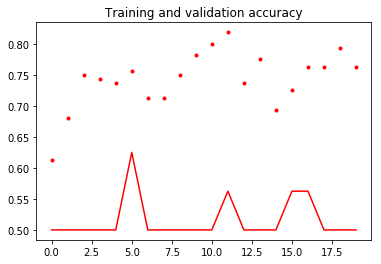

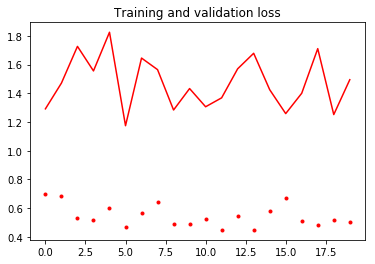

In [23]:
train(epochs = 20, output_model_file = 'EffB5_new_model.h5')

## Predictions on test data

In [0]:
target_size = (299, 299) # for EfficientnetB5

In [0]:
def predict(model, img, target_size = target_size):
    img = cv2.imread(img)
    img = cv2.resize(img,(299,299))
    x = np.reshape(img,[299,299,3])
    x = np.expand_dims(x, axis=0)
   # x = preprocess_input(x)
    preds = model.predict(x)
    return preds[0]

In [0]:
def plot_preds(image, preds):
    labels = ("NORMAL", "PNEUMONIA")
    plt.barh([0, 1], preds, alpha=0.5)
    plt.yticks([0, 1], labels)
    plt.xlabel('Probabilities')
    plt.xlim(0,1.01)
    plt.tight_layout()

In [0]:
# Load saved model
model = load_model('EfficientNetB5_weights_5.h5')

### 0: Normal    1: Pneumonia

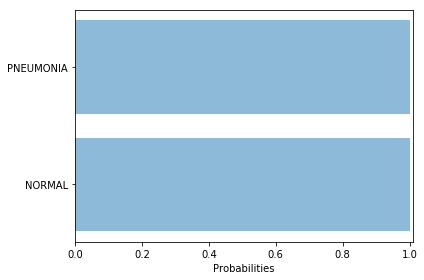

In [30]:
# Pred 1
img =  './chest_xray/test/PNEUMONIA/person48_virus_100.jpeg'
preds = predict(model, img)
plot_preds(img, preds)

In [31]:
res = np.argmax(preds)
print(res)   

0


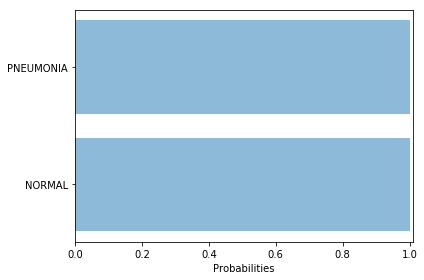

In [32]:
# Pred 2
img =  './chest_xray/test/NORMAL/IM-0105-0001.jpeg'
preds = predict(model, img)
plot_preds(img, preds)

In [33]:
res = np.argmax(preds)
print(res)   

0


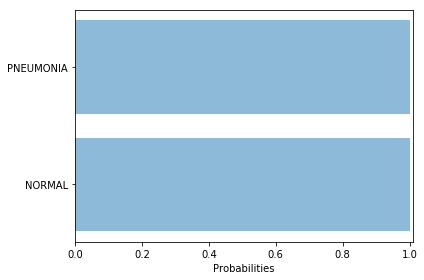

In [34]:
# Pred 3
img =  './chest_xray/test/PNEUMONIA/person1672_virus_2888.jpeg'
preds = predict(model, img)
plot_preds(img, preds)

In [35]:
res = np.argmax(preds)
print(res)   

0
